#      transfer learninng


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from pathlib import Path
root=Path("data")
root.mkdir(exist_ok=True)
path=Path(root)/"'fmnist_small.csv"

In [4]:
df = pd.read_csv(path)
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [5]:
df.shape

(6000, 785)

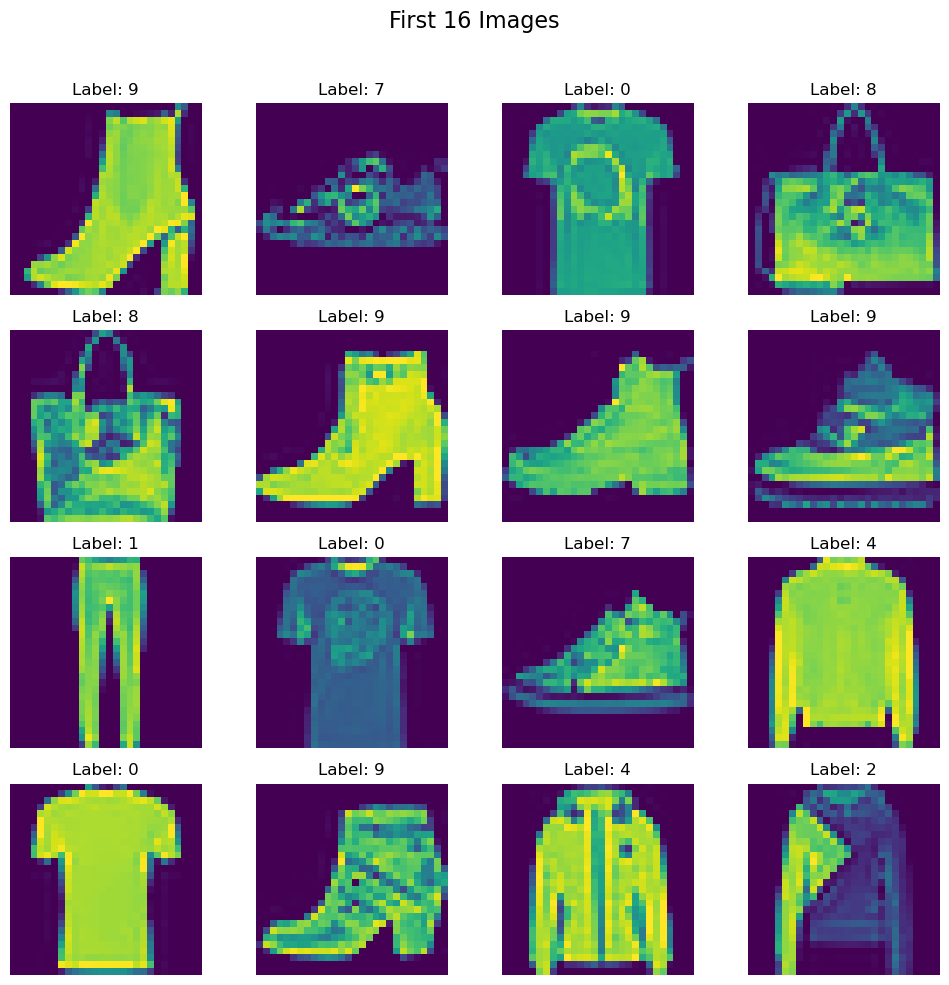

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from torchvision import transforms

# Define data augmentations for the training dataset
custom_transform = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop (224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  ])

In [10]:
from PIL import Image
import numpy as np
class CustomDataset (Dataset):
    
    def __init__(self, features, labels, transforms):
        self.features = features
        self.label = labels
        self.transform = transforms
        
    def __len__(self):
         return len(self.features)
    
    def __getitem__(self,index):
        
        #resize to (28, 28)
        image =self.features[index].reshape(28,28)
        
        #change datatype to np.uint8
        image =image.astype(np.uint8)
        
        # change black&white to color -> (H,W,C) -> (C,H,W)
        image = np.stack([image]*3, axis=-1)
        
        #convert array to PIL image
        image = Image.fromarray(image)
        
        #apply transforms
        image = self.transform(image)
        
        # return
        return image, torch.tensor(self.label[index], dtype=torch.long)

In [11]:
train_dataset = CustomDataset(X_train, y_train, custom_transform)
test_dataset = CustomDataset(X_test, y_test, custom_transform)

In [12]:
from torch.utils.data import DataLoader
#Setup the batch size hyperparameter
BATCH_SIZE = 4
#Turn datasets into iterables (batches)
train_dataloader=DataLoader (
                            dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader=DataLoader (dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x286b0e4f0e0>,
 <torch.utils.data.dataloader.DataLoader at 0x286b0ea0050>)

In [13]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained = True)

D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [16]:
for param in vgg16.features.parameters():
    param.requires_grad=False

In [17]:
vgg16.classifier=nn.Sequential(
     nn.Linear(in_features=25088, out_features=1024),
     nn.ReLU(),
     nn.Dropout(p=0.5),
     nn.Linear(in_features=1024, out_features=512),
     nn.ReLU(),
     nn.Dropout(p=0.5),
     nn.Linear(in_features=512, out_features=10)  )

In [18]:
vgg16.to("cuda")

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
learnining_rate=0.0001
epochs=4

In [20]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(vgg16.classifier.parameters(),lr=learnining_rate)

In [21]:
from timeit import default_timer as timer

def accuracy_fn(y_true, y_pred):
        correct=torch.eq(y_true, y_pred).sum().item()
        acc=(correct/len(y_pred)) * 100
        return acc
    
def print_train_time(start:float, end:float, device:torch.device=None):
        # time differernce btw start and end
        total_time=end-start
        print(f"train time : {total_time:.3f} seconds")
        return total_time

In [22]:
def train_and_test(model: torch.nn.Module,
              train_dataloader:torch.utils.data.DataLoader,
              test_dataloader:torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim,
              epochs:int,
              accuracy_fn,
              device: torch.device=device):
    # import tqdm for progress bar
    from tqdm.auto import tqdm
    
    # set the seed and start the timer
    torch.manual_seed(42)
    train_time_start_on_cpu = timer()
    
    # create training and testing loop
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n----------")
        ## training
        train_loss,train_acc = 0,0
        # add a loop to loop through the training batches
        for batch, (x, y) in enumerate(train_dataloader):
            x,y=x.to(device),y.to(device)
            model.train()
            # forward pass
            y_pred = model(x)
    
            # calculate the loss
            loss = loss_fn(y_pred, y)
            train_acc+=accuracy_fn(y,y_pred.argmax(dim=1))
            train_loss += loss
    
            # optimze zerograd
            optimizer.zero_grad()
    
            # loss backword
            loss.backward()
    
            # optimizer setp
            optimizer.step()
    
            # print some thing whats hapening
            if batch % 400 == 0:
                print(f"looked at {batch * len(x)}/{len(train_dataloader.dataset)} samples.")
        train_loss/=len(train_dataloader)
        train_acc/=len(train_dataloader)
        
        ### Testing
        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X_test, y_test in test_dataloader:
                # 1. Forward pass
                X_test, y_test=X_test.to(device), y_test.to(device)
                test_pred=model(X_test)
                # 2. Calculate loss (accumulatively)
                test_loss += loss_fn(test_pred, y_test)
                # 3. Calculate accuracy
                test_acc += accuracy_fn(y_true=y_test, y_pred= test_pred.argmax(dim=1))
            # Calculate the test loss average per batch
            test_loss /= len(test_dataloader)
            # Calculate the test acc average per batch
            test_acc /= len(test_dataloader)
        # print out what's happening
        print(f"\nTrain loss: {train_loss:.4f}, Train acc: {test_acc:.4f} | test loss: {test_loss:.4f}, test acc: {test_acc:.4f}")
    
    # calculate training time
    train_time_end_on_cpu = timer()
    total_train_time_model = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=str(next(model.parameters())))
    return total_train_time_model

In [23]:
train_and_test(model=vgg16,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              loss_fn= loss_fn,
              optimizer=optimizer,
              epochs=epochs,
              accuracy_fn=accuracy_fn,
              device="cuda")

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
----------
looked at 0/4800 samples.
looked at 1600/4800 samples.
looked at 3200/4800 samples.

Train loss: 0.6532, Train acc: 87.3333 | test loss: 0.3551, test acc: 87.3333
Epoch: 1
----------
looked at 0/4800 samples.
looked at 1600/4800 samples.
looked at 3200/4800 samples.

Train loss: 0.3171, Train acc: 88.6667 | test loss: 0.3490, test acc: 88.6667
Epoch: 2
----------
looked at 0/4800 samples.
looked at 1600/4800 samples.
looked at 3200/4800 samples.

Train loss: 0.2043, Train acc: 86.7500 | test loss: 0.4260, test acc: 86.7500
Epoch: 3
----------
looked at 0/4800 samples.
looked at 1600/4800 samples.
looked at 3200/4800 samples.

Train loss: 0.1327, Train acc: 88.5000 | test loss: 0.4109, test acc: 88.5000
train time : 174.696 seconds


174.6958897000004